**the order in which you use the shared amazing magic notes, I think this is very important
I think now this order is good, but please let us know your opinion.**

1. wifi feauture prediction
1. blend
1. Cost Minimization
1. Snap to Grid

Added mapping before and after post-processing, Thanks for the great notes

**refarence**

[Indoor Navigation - "Snap to Grid" Post Processing](https://www.kaggle.com/robikscube/indoor-navigation-snap-to-grid-post-processing)

[Ensembling best performing notebooks ver15](https://www.kaggle.com/saurabhbagchi/ensembling-best-performing-notebooks?scriptVersionId=56617696)

[indoor - Post-processing by Cost Minimization](https://www.kaggle.com/saitodevel01/indoor-post-processing-by-cost-minimization)

[Simple 👌 99% Accurate Floor Model 💯](https://www.kaggle.com/nigelhenry/simple-99-accurate-floor-model)

[How to check your submission [LB4.441]](https://www.kaggle.com/yamsam/how-to-check-your-submission-lb4-441)

In [1]:
!git clone --depth 1 https://github.com/location-competition/indoor-location-competition-20 indoor_location_competition_20
!rm -rf indoor_location_competition_20/data

Cloning into 'indoor_location_competition_20'...
remote: Enumerating objects: 1169, done.
remote: Counting objects: 100% (1169/1169), done.
remote: Compressing objects: 100% (1131/1131), done.
remote: Total 1169 (delta 38), reused 1167 (delta 38), pack-reused 0
Receiving objects: 100% (1169/1169), 411.37 MiB | 15.80 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Checking out files: 100% (1145/1145), done.


In [2]:
file_name = "../input/villageindoorbestsubmissions/sub_cost_snap_lb4.549.csv"

In [3]:
import multiprocessing
import numpy as np
import pandas as pd
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm

from indoor_location_competition_20.io_f import read_data_file
import indoor_location_competition_20.compute_f as compute_f

In [4]:
INPUT_PATH = '../input/indoor-location-navigation'

In [5]:
def compute_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions

In [6]:
def correct_path(args):
    
    path, path_df = args
#     print(type(path), type(path_df))
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    
    example = read_data_file(f'{INPUT_PATH}/test/{path}.txt')
    rel_positions = compute_rel_positions(example.acce, example.ahrs)
    
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)
    N = xy_hat.shape[0]
    
    delta_t = np.diff(T_ref)
    
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.4 + 0.4 * 1e-3 * delta_t)**(-2)
    
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags(beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))

    xy_star = scipy.sparse.linalg.spsolve(Q, c)
    
    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })

In [7]:
sub = pd.read_csv(file_name)
tmp = sub['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
sub['site'] = tmp[0]
sub['path'] = tmp[1]
sub['timestamp'] = tmp[2].astype(float)

processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, sub.groupby('path'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
sub = pd.concat(dfs).sort_values('site_path_timestamp')
sub.to_csv('submission.csv', index=False)

626it [06:45,  1.54it/s]


In [8]:
import json
import matplotlib.pylab as plt

def split_col(df):
    df = pd.concat([
        df['site_path_timestamp'].str.split('_', expand=True) \
        .rename(columns={0:'site',
                         1:'path',
                         2:'timestamp'}),
        df
    ], axis=1).copy()
    return df

floor_map = {"B2":-2, "B1":-1, "F1":0, "F2": 1, "F3":2,
             "F4":3, "F5":4, "F6":5, "F7":6,"F8":7,"F9":8,
             "1F":0, "2F":1, "3F":2, "4F":3, "5F":4, "6F":5,
             "7F":6, "8F": 7, "9F":8}


def plot_preds(
    site,
    floorNo,
    sub=None,
    true_locs=None,
    base="../input/indoor-location-navigation",
    show_train=True,
    show_preds=True,
    fix_labels=True,
    map_floor=None
):
    """
    Plots predictions on floorplan map.
    
    map_floor : use a different floor's map
    """
    if map_floor is None:
        map_floor = floorNo
    # Prepare width_meter & height_meter (taken from the .json file)
    floor_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
    json_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_info.json"
    with open(json_plan_filename) as json_file:
        json_data = json.load(json_file)

    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]

    floor_img = plt.imread(f"{base}/metadata/{site}/{map_floor}/floor_image.png")

    fig, ax = plt.subplots(figsize=(12, 12))
    plt.imshow(floor_img)

    if show_train:
        true_locs = true_locs.query('site == @site and floorNo == @map_floor').copy()
        true_locs["x_"] = true_locs["x"] * floor_img.shape[0] / height_meter
        true_locs["y_"] = (
            true_locs["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        true_locs.query("site == @site and floorNo == @map_floor").groupby("path").plot(
            x="x_",
            y="y_",
            style="+",
            ax=ax,
            label="train waypoint location",
            color="grey",
            alpha=0.5,
        )

    if show_preds:
        sub = sub.query('site == @site and floorNo == @floorNo').copy()
        sub["x_"] = sub["x"] * floor_img.shape[0] / height_meter
        sub["y_"] = (
            sub["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        for path, path_data in sub.query(
            "site == @site and floorNo == @floorNo"
        ).groupby("path"):
            path_data.plot(
                x="x_",
                y="y_",
                style=".-",
                ax=ax,
                title=f"{site} - floor - {floorNo}",
                alpha=1,
                label=path,
            )
    if fix_labels:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(
            by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5)
        )
    return fig, ax

def sub_process(sub, train_waypoints):
    train_waypoints['isTrainWaypoint'] = True
    sub = split_col(sub[['site_path_timestamp','floor','x','y']]).copy()
    sub = sub.merge(train_waypoints[['site','floorNo','floor']].drop_duplicates(), how='left')
    sub = sub.merge(
        train_waypoints[['x','y','site','floor','isTrainWaypoint']].drop_duplicates(),
        how='left',
        on=['site','x','y','floor']
             )
    sub['isTrainWaypoint'] = sub['isTrainWaypoint'].fillna(False)
    return sub.copy()

In [9]:
sub = split_col(sub)
th = 5

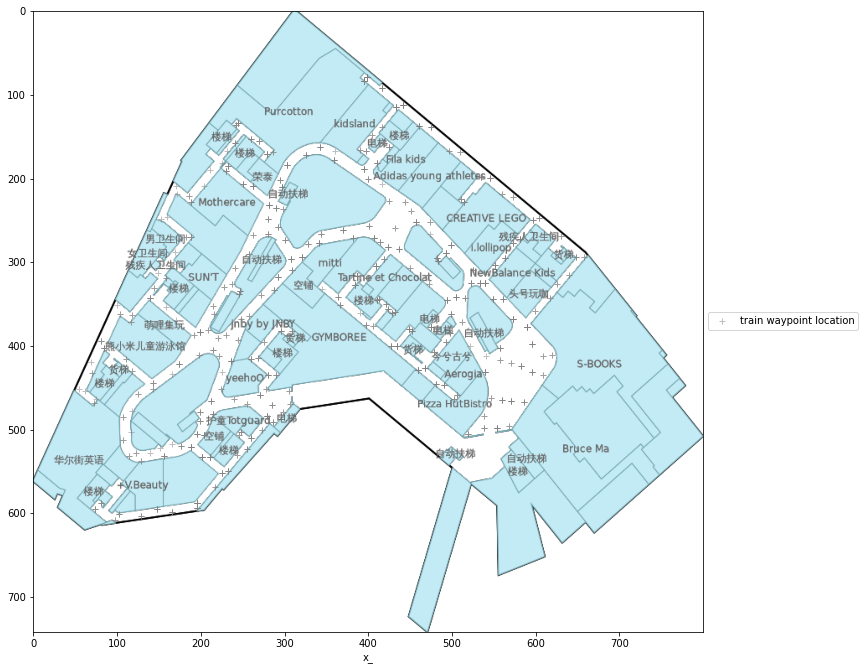

In [10]:
train_waypoints = pd.read_csv('../input/indoor-location-train-waypoints/train_waypoints.csv')
sub = sub_process(sub, train_waypoints)
# Plot the training Data For an example Floor
example_site = '5dbc1d84c1eb61796cf7c010'
example_floorNo = 'F3'

plot_preds(example_site, example_floorNo, sub,
           train_waypoints, show_preds=False)
plt.show()

In [11]:
from scipy.spatial.distance import cdist

def add_xy(df):
    df['xy'] = [(x, y) for x,y in zip(df['x'], df['y'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

sub = add_xy(sub)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in sub.groupby(['site','floor']):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

sub = pd.concat(ds)

In [12]:
def snap_to_grid(sub, threshold):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    sub['_x_'] = sub['x']
    sub['_y_'] = sub['y']
    sub.loc[sub['dist'] < threshold, '_x_'] = sub.loc[sub['dist'] < threshold]['x_']
    sub.loc[sub['dist'] < threshold, '_y_'] = sub.loc[sub['dist'] < threshold]['y_']
    return sub.copy()

# Calculate the distances
sub['dist'] = np.sqrt( (sub.x-sub.x_)**2 + (sub.y-sub.y_)**2 )

sub_pp = snap_to_grid(sub, threshold=th)

sub_pp = sub_pp[['site_path_timestamp','floor','_x_','_y_','site','path','floorNo']] \
    .rename(columns={'_x_':'x', '_y_':'y'})

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


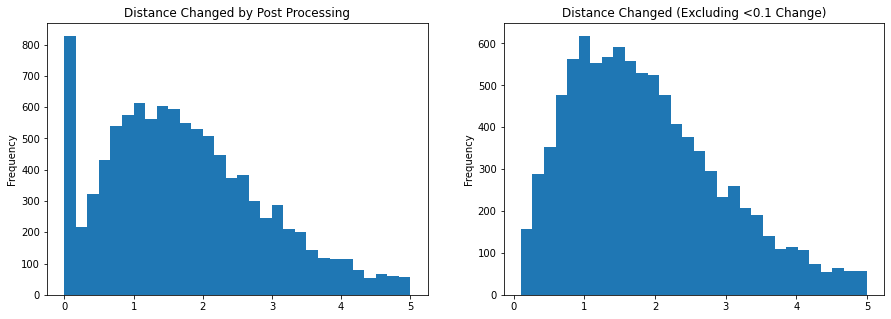

In [13]:
sub['dist_pp_change'] = np.sqrt(((sub['x'] - sub['_x_']) ** 2) + ((sub['y'] - sub['_y_']) ** 2))
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sub['dist_pp_change'].plot(kind='hist', bins=30,
                           ax=axs[0],
                           title='Distance Changed by Post Processing')
sub.query('dist_pp_change > 0.1')['dist_pp_change'] \
    .plot(kind='hist', bins=30, ax=axs[1],
          title='Distance Changed (Excluding <0.1 Change)')

plt.show()

<AxesSubplot:ylabel='site,floorNo'>

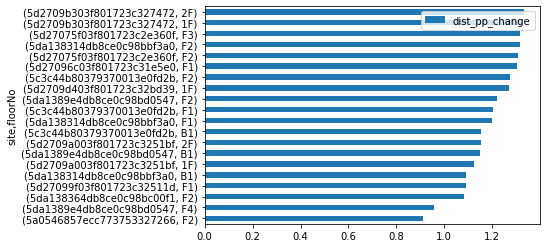

In [14]:
sub.groupby(['site','floorNo'])['dist_pp_change'].mean() \
    .reset_index() \
    .sort_values('dist_pp_change') \
    .set_index(['site','floorNo']).head(20).plot(kind='barh')

In [15]:
sub_pp[['site_path_timestamp','floor','x','y']] \
    .to_csv('sub_cost_snap.csv', index=False)

In [16]:
import json
import re
import gc
import pickle
import itertools
from glob import glob
from datetime import datetime as dt
from pathlib import Path
from tqdm import tqdm
import datetime
ts_conv = np.vectorize(datetime.datetime.fromtimestamp) # ut(10 digit) -> date

# pandas settings -----------------------------------------
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.options.display.float_format = '{:,.5f}'.format

# Graph drawing -------------------------------------------
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
from matplotlib_venn import venn2, venn2_circles
from matplotlib import animation as ani
from IPython.display import Image
from pylab import imread

plt.rcParams["patch.force_edgecolor"] = True
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

%matplotlib inline
%config InlineBackend.figure_format='retina'

# ML -------------------------------------------
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.simplefilter('ignore')

In [17]:
pred_df = pd.read_csv(file_name) 
after_df = pd.read_csv('./sub_cost_snap.csv')

In [18]:
pred_df['site'] = [s1 for s1, s2, s3 in pred_df.site_path_timestamp.str.split('_')]
pred_df['path'] = [s2 for s1, s2, s3 in pred_df.site_path_timestamp.str.split('_')]
pred_df['timestamp'] = [s3 for s1, s2, s3 in pred_df.site_path_timestamp.str.split('_')]

after_df['site'] = [s1 for s1, s2, s3 in pred_df.site_path_timestamp.str.split('_')]
after_df['path'] = [s2 for s1, s2, s3 in pred_df.site_path_timestamp.str.split('_')]
after_df['timestamp'] = [s3 for s1, s2, s3 in pred_df.site_path_timestamp.str.split('_')]

In [19]:

class SiteInfo():
    def __init__(self, site_id, floor, input_path="../input/indoor-location-navigation/"):
        self.site_id = site_id
        self.floor = floor
        self.input_path = input_path
        assert Path(input_path).exists(), f"input_path do not exist: {input_path}"
        
    def get_site_info(self, keep_raw=False):
        floor_info_path = f"{self.input_path}/metadata/{self.site_id}/{self.floor}/floor_info.json"
        with open(floor_info_path, "r") as f:
            self.floor_info = json.loads(f.read())
            self.site_height = self.floor_info["map_info"]["height"]
            self.site_width = self.floor_info["map_info"]["width"]
            if not keep_raw:
                del self.floor_info
            
        geojson_map_path = f"{self.input_path}/metadata/{self.site_id}/{self.floor}/geojson_map.json"
        with open(geojson_map_path, "r") as f:
            self.geojson_map = json.loads(f.read())
            self.map_type = self.geojson_map["type"]
            self.features = self.geojson_map["features"]
            
            self.floor_coordinates = self.features[0]["geometry"]["coordinates"]
            self.store_coordinates = [self.features[i]["geometry"]["coordinates"] 
                                          for i in range(1, len(self.features))]
                
            if not keep_raw:
                del self.geojson_map
    
    def show_site_image(self):
        path = f"{self.input_path}/metadata/{self.site_id}/{self.floor}/floor_image.png"
        plt.imshow(imread(path), extent=[0, self.site_width, 0, self.site_height])

    def draw_polygon(self, size=8, only_floor=False):

        fig = plt.figure()
        ax = plt.subplot(111)
            
        xmax, xmin, ymax, ymin = self._draw(self.floor_coordinates, ax, calc_minmax=True)
        if not only_floor:
            self._draw(self.store_coordinates, ax, fill=True)
        plt.legend([])
        
        xrange = xmax - xmin
        yrange = ymax - ymin
        ratio = yrange / xrange
        
        self.x_size = size
        self.y_size = size*ratio

        fig.set_figwidth(size)
        fig.set_figheight(size*ratio)
        # plt.show()
        return ax
        
    def _draw(self, coordinates, ax, fill=False, calc_minmax=False):
        xmax, ymax = -np.inf, -np.inf
        xmin, ymin = np.inf, np.inf
        for i in range(len(coordinates)):
            ndim = np.ndim(coordinates[i])
            if ndim==2:
                corrd_df = pd.DataFrame(coordinates[i])
                if fill:
                    ax.fill(corrd_df[0], corrd_df[1], alpha=0.7)
                else:
                    corrd_df.plot.line(x=0, y=1, style="-", ax=ax)
                        
                if calc_minmax:
                    xmax = max(xmax, corrd_df[0].max())
                    xmin = min(xmin, corrd_df[0].min())

                    ymax = max(ymax, corrd_df[1].max())
                    ymin = min(ymin, corrd_df[1].min())
            elif ndim==3:
                for j in range(len(coordinates[i])):
                    corrd_df = pd.DataFrame(coordinates[i][j])
                    if fill:
                        ax.fill(corrd_df[0], corrd_df[1], alpha=0.6)
                    else:
                        corrd_df.plot.line(x=0, y=1, style="-", ax=ax)
                        
                    if calc_minmax:
                        xmax = max(xmax, corrd_df[0].max())
                        xmin = min(xmin, corrd_df[0].min())

                        ymax = max(ymax, corrd_df[1].max())
                        ymin = min(ymin, corrd_df[1].min())
            else:
                assert False, f"ndim of coordinates should be 2 or 3: {ndim}"
        if calc_minmax:
            return xmax, xmin, ymax, ymin
        else:
            return None
        

In [20]:
floor_convert = {'1F' :  0, '2F' : 1, '3F' : 2, '4F' : 3, '5F' : 4, 
                     '6F' : 5, '7F' : 6, '8F' : 7, '9F' : 8,
                     'B'  : -1, 'B1' : -1, 'B2' : -2, 'B3' : -3, 
                     'BF' : -1, 'BM' : -1, 
                     'F1' : 0, 'F2' : 1, 'F3' : 2, 'F4' : 3, 'F5' : 4, 
                     'F6' : 5, 'F7' : 6, 'F8' : 7, 'F9' : 8, 'F10': 9,
                     'L1' : 0, 'L2' : 1, 'L3' : 2, 'L4' : 3, 'L5' : 4, 
                     'L6' : 5, 'L7' : 6, 'L8' : 7, 'L9' : 8, 'L10': 9, 
                     'L11': 10,
                     'G'  : 0, 'LG1': 0, 'LG2': 1, 'LM' : 0, 'M'  : 0, 
                     'P1' : 0, 'P2' : 1,}

In [21]:
reconv = {}

for i in range(20):
    reconv[i - 5] = []
    
for k, v in floor_convert.items(): 
    reconv[v].append(k) 

train_dir='../input/indoor-navigation-and-location-wifi-features/' 

In [22]:
for i, site_id in enumerate(pred_df.site.unique()):

    sample_df = pred_df.query("site == @site_id")
    after_s_df = after_df.query("site == @site_id")
    
    train_df = pd.read_csv(f'{train_dir}/{site_id}_train.csv')
    
    for floor_id in sample_df['floor'].unique():
        floor_df = sample_df[sample_df['floor'] == floor_id].reset_index(drop=True)
        after_f_df = after_s_df[after_s_df['floor'] == floor_id].reset_index(drop=True)

        for fstr in reconv[floor_id]:
            sample_map = SiteInfo(site_id, fstr)
            try:
                sample_map.get_site_info()
            except:
                pass
            else:
                break

        plt.figure(figsize=(12, 12*sample_map.site_height / sample_map.site_width))
        #plt.subplot(121)
        
        sample_map.show_site_image()

        for _, g in floor_df.groupby("path"):
            plt.plot(g.x, g.y, "-o", alpha=0.6,  zorder=100, markersize=5)
        
        sample_train = train_df.query('f == @floor_id')
        
        plt.scatter(sample_train.x, sample_train.y, marker='+', s=3)
        plt.title(f'before {site_id}:{floor_id}')
        
        for fstr in reconv[floor_id]:
            sample_map = SiteInfo(site_id, fstr)
            try:
                sample_map.get_site_info()
            except:
                pass
            else:
                break   
                
        plt.figure(figsize=(12, 12*sample_map.site_height / sample_map.site_width))
        #plt.subplot(121)
        
        sample_map.show_site_image()

        for _, g in after_f_df.groupby("path"):
            plt.plot(g.x, g.y, "-o", alpha=0.6,  zorder=100, markersize=5)
            
#        plt.title(f'pred {site_id}:{floor_id}')
        
        sample_train = train_df.query('f == @floor_id')
        
#        plt.subplot(122)
#        sample_map.show_site_image()
        
        #for _, g in sample_train.groupby("path"):
        #    plt.plot(g.x, g.y, "-o", alpha=0.6,  zorder=100, markersize=5)
        
        plt.scatter(sample_train.x, sample_train.y, marker='+', s=3)
        plt.title(f'post_process {site_id}:{floor_id}')
    
        # show all floor in this site
        break 
    #break

FileNotFoundError: [Errno 2] No such file or directory: '../input/indoor-navigation-and-location-wifi-features//5a0546857ecc773753327266_train.csv'